In [2]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
import os

In [9]:
wd = os.getcwd()
input_dir = os.path.join(wd,'input')
input_images = os.path.join(input_dir,'images')

In [11]:
df = pd.read_csv(input_dir+'/'+'stage_1_train_labels.csv')

In [13]:
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [24]:
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [25]:
df[df.patientId =='0a0f91dc-6015-4342-b809-d19610854a21']

,patientId,x,y,width,height,Target
757,0a0f91dc-6015-4342-b809-d19610854a21,646.0,465.0,200.0,168.0,1


In [16]:
patientId = '0a0f91dc-6015-4342-b809-d19610854a21'
dcm_file = input_images+'/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1915.1517874293.598027
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0a0f91dc-6015-4342-b809-d19610854a21'
(0010, 0020) Patient ID                          LO: '0a0f91dc-6015-4342-b809-d19610854a21'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

In [18]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

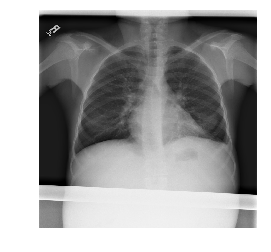

In [19]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [50]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': input_images+'/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [51]:
parsed = parse_data(df)

In [52]:
print(parsed['0a0f91dc-6015-4342-b809-d19610854a21'])

{'dicom': '/Users/nabeel/Projects/Kaggle/RSNA_Pneumonia/input/images/0a0f91dc-6015-4342-b809-d19610854a21.dcm', 'label': 1, 'boxes': [[465.0, 646.0, 168.0, 200.0]]}


In [53]:
eg1 = parsed['0a0f91dc-6015-4342-b809-d19610854a21']

In [54]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

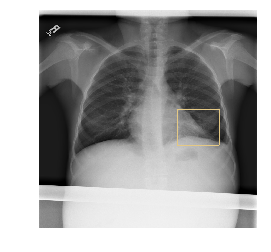

In [55]:
draw(eg1)

In [56]:
df_detailed = pd.read_csv(input_dir+'/stage_1_detailed_class_info.csv')
print(df_detailed.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


In [57]:
summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
print(summary)

{'No Lung Opacity / Not Normal': 11500, 'Normal': 8525, 'Lung Opacity': 8964}
